# Flow(홍수정님)

![image](pix2pix.png)

# 프로젝트 수행 사항

1. 데이터에 한 가지 이상의 `augmentation 방법을 적용`하여 학습해 주세요.(어떠한 방법을 사용했는지 적어주세요.)
2. 이전에 구현했던 `두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용`해 주세요.
3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 `"val" 폴더 내 이미지를 사용`해 주세요.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 `시각화`해 주세요.
5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 `손실 값에 대한 로그`를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

## 평가지표

|No|평가지표|상세사항|
|:---:|:---|:---|
|1|pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.|데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.|
|2|pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다|U-Net generator, discriminator 모델 구현이 완료되어 train_step의 output을 확인하고 개선하였다.|
|3|학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.|10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.|

## pix2pix 

- Pix2Pix는 기존 노이즈 입력을 이미지로 변환하는 일반적인 GAN이 아니라, 이미지를 입력으로 하여 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN 모델.

- 한 이미지의 픽셀에서 다른 이미지의 픽셀로(pixel to pixel) 변환한다는 뜻. 

- 최근 활발하게 연구 및 응용되는 GAN 기반의 Image-to-Image Translation 작업에서 가장 기초가 됨.

- 노이즈와 레이블 정보를 함께 입력했던 cGAN은 fully-connected 레이어를 연속적으로 쌓아 만들었지만, `이미지 변환이 목적인 Pix2Pix는 이미지를 다루는데 효율적인 convolution 레이어를 활용`됨.

![image](https://velog.velcdn.com/images%2Fwilko97%2Fpost%2Fa785b691-b431-4f0e-ae1a-c86af3996323%2Fimage.png)


pix2pix = cgan + paired image generator - noise vector

noise vector 대신 image를 입력으로 받음 <- Unet 활용 (generator)



[cgan 관련자료 1](https://aistudy9314.tistory.com/75)  

[cgan 관련자료 2](https://velog.io/@wilko97/%EB%85%BC%EB%AC%B8%EC%8B%A4%EC%8A%B5-Pix2Pix)


## Discriminator of Pix2Pix

![image](https://d3s0tskafalll9.cloudfront.net/media/images/patchgan.max-800x600.png)

Discriminator가 특이하다는데 모르겠음 지금 매우 혼미

## 압축 풀기

In [1]:
# import zipfile

# # 압축 파일 경로
# zip_file_path = "data/cityscapes.zip"

# # 압축 해제할 폴더 경로
# extract_folder_path = "cityscapes"

# # 압축 파일 열기
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     # 압축 해제
#     zip_ref.extractall(extract_folder_path)

# print("압축 파일이 성공적으로 해제되었습니다.")


## 임포트

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers

# 0. 데이터 로드

In [3]:
# train 경로를 지정해주세요
train_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("train 개수 :", len(os.listdir(train_path)))

train 개수 : 1000


## 0.1) 데이터 살펴보기

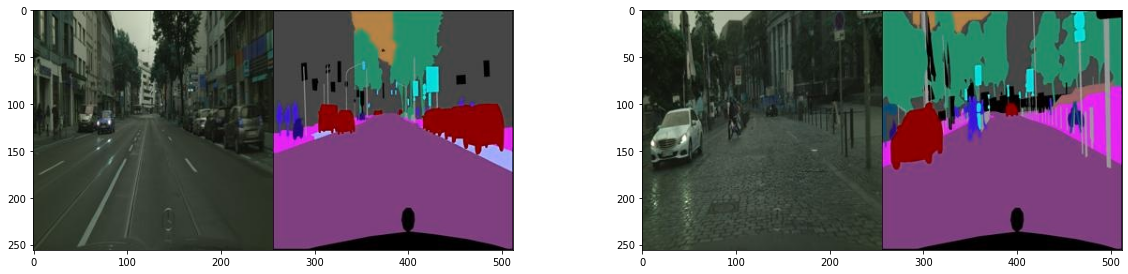

In [4]:
plt.figure(figsize=(20,15))
for i in range(1, 3):
    f = train_path + os.listdir(train_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

## 0.2) Augmentation 적용

- `(수행사항 1)` 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해 주세요.(어떠한 방법을 사용했는지 적어주세요.)

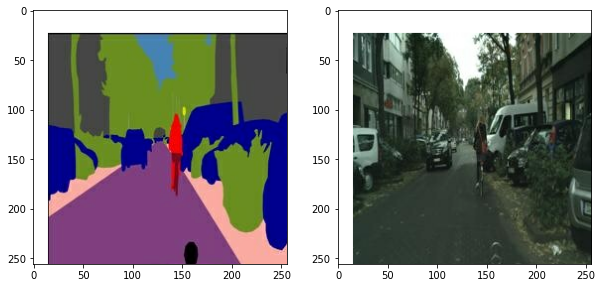

In [5]:
def normalize(x):
    '''
    정규화 
    '''
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    '''
    역정규화
    '''
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    '''
    이미지 sketch와 colored로 나누기 
    '''
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

@tf.function()
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        # 데이터를 반사(reflect) 모드로 패딩
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        # 데이터를 상수(constant) 값으로 패딩
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    # 이미지를 무작위로 잘라내기
    out = image.random_crop(padded, size=[256, 256, 6])
    
    # 이미지를 무작위로 좌우 반전
    out = image.random_flip_left_right(out)
    
    # 이미지를 무작위로 상하 반전
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        # 이미지를 무작위로 회전
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    # 결과를 스케치 이미지와 컬러 이미지로 분리하여 반환
    return out[...,:3], out[...,3:]


def get_train(img_path):
#     sketch, colored = load_img(img_path)
    colored, sketch = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

# 훈련 이미지 데이터셋 생성
train_images = data.Dataset.list_files(train_path + "*.jpg")

# get_train 함수를 적용하여 이미지 데이터 전처리 및 셔플링, 배치 처리
train_images = train_images.map(get_train).shuffle(100).batch(4)

# 샘플 이미지 가져오기
sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

# 시각화
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))


# 1. Generator

## 1.1) (일반) Generator

![image](https://d3s0tskafalll9.cloudfront.net/media/images/refer_g.max-800x600.png)

### 1.1.1) (일반) Encoder

In [6]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)
    
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

### 1.1.2) (일반) Decoder

In [7]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

### 1.1.3) (일반) Genertor 선언

In [8]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


## 1.2) U-Net Generator

### 1.2.1) (U-Net) Encoder

In [9]:
class EncodeBlock_Unet(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock_Unet, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

### 1.2.2) (U-Net) Decoder

In [10]:
class DecodeBlock_Unet(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock_Unet, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

### 1.2.3) (U-Net) Generator 선언

In [11]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock_Unet(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock_Unet(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock_Unet(f))
            else:
                self.decode_blocks.append(DecodeBlock_Unet(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block__unet (EncodeBlock (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block__unet_1 (EncodeBlo (None, 64, 64, 128)  131584      encode_block__unet[0][0]         
__________________________________________________________________________________________________
encode_block__unet_2 (EncodeBlo (None, 32, 32, 256)  525312      encode_block__unet_1[0][0]       
____________________________________________________________________________________________

# 2. Discriminator

![image](https://d3s0tskafalll9.cloudfront.net/media/images/refer_d.max-800x600.png)

In [12]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [13]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
Discriminator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

# 3. 학습

## 3.1) Loss 선언

In [14]:

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

## 3.2) Optimizer 선언

In [15]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

## 3.3) 학습 코드 & 가중치 계산

In [16]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

- `(수행사항 2)` 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해 주세요.

In [17]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

# 손실 기록 리스트
g_losses = []
l1_losses = []
d_losses = []

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        
        # 손실 기록
        g_losses.append(g_loss.numpy())
        l1_losses.append(l1_loss.numpy())
        d_losses.append(d_loss.numpy())
        
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[100]                     
Generator_loss:1.0989                     
L1_loss:0.1833                     
Discriminator_loss:1.5747

EPOCH[1] - STEP[200]                     
Generator_loss:1.8346                     
L1_loss:0.1602                     
Discriminator_loss:1.7357

EPOCH[2] - STEP[100]                     
Generator_loss:1.2083                     
L1_loss:0.1890                     
Discriminator_loss:0.6361

EPOCH[2] - STEP[200]                     
Generator_loss:0.9053                     
L1_loss:0.1811                     
Discriminator_loss:0.8872

EPOCH[3] - STEP[100]                     
Generator_loss:2.3379                     
L1_loss:0.1566                     
Discriminator_loss:0.9919

EPOCH[3] - STEP[200]                     
Generator_loss:1.5460                     
L1_loss:0.1725                     
Discriminator_loss:0.4556

EPOCH[4] - STEP[100]                     
Generator_loss:2.4796                     
L1_loss:0.2017             

# 4. Val 테스트

- `(수행사항 3)` 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요

- `(수행사항 4)` 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.

## 10 epoch

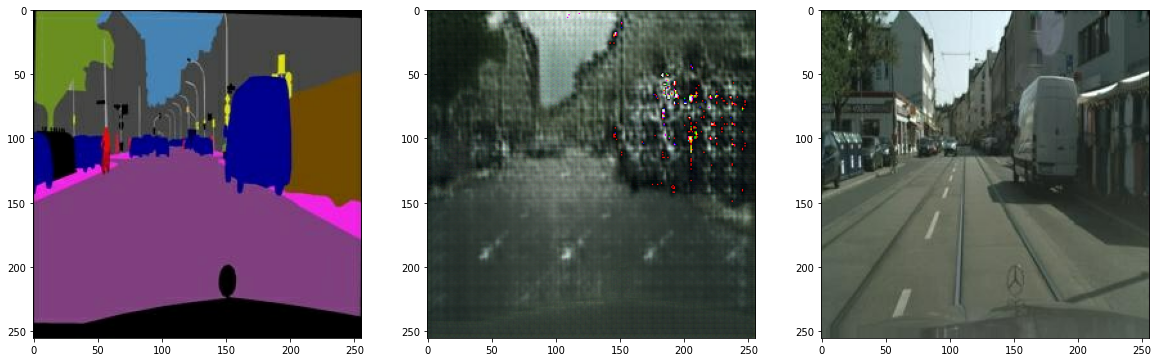

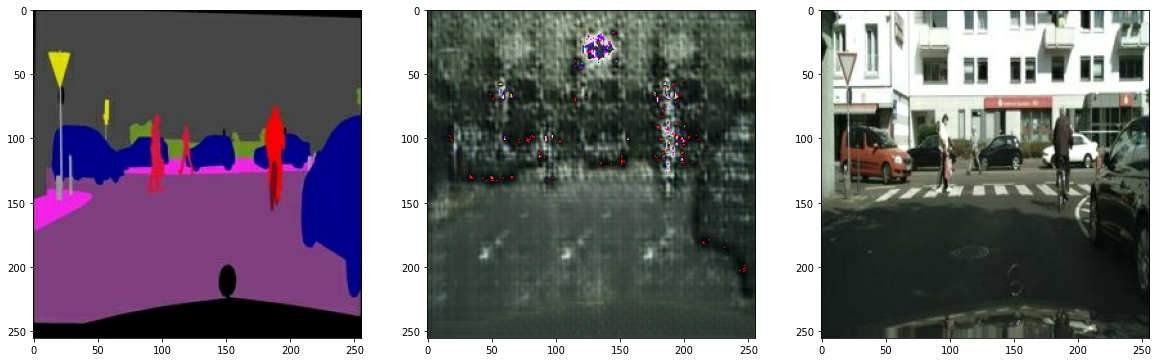

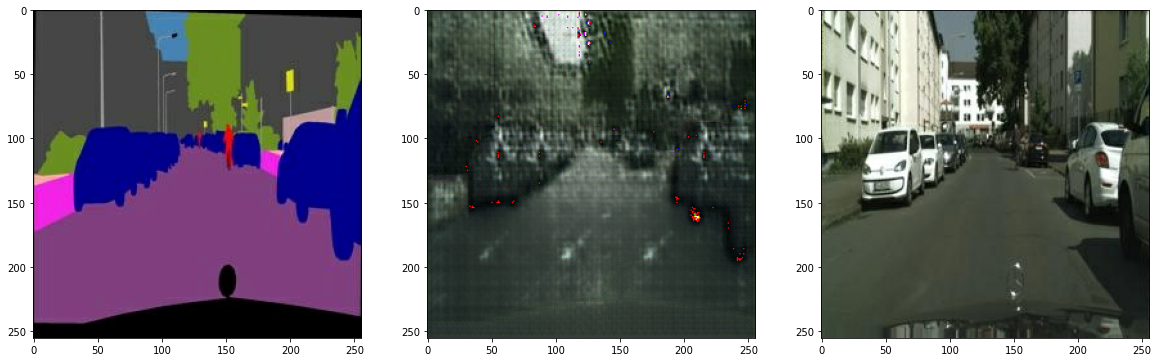

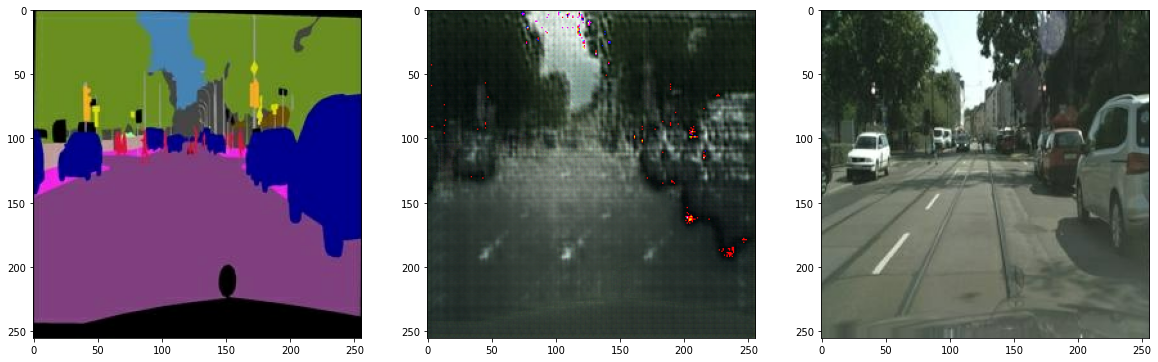

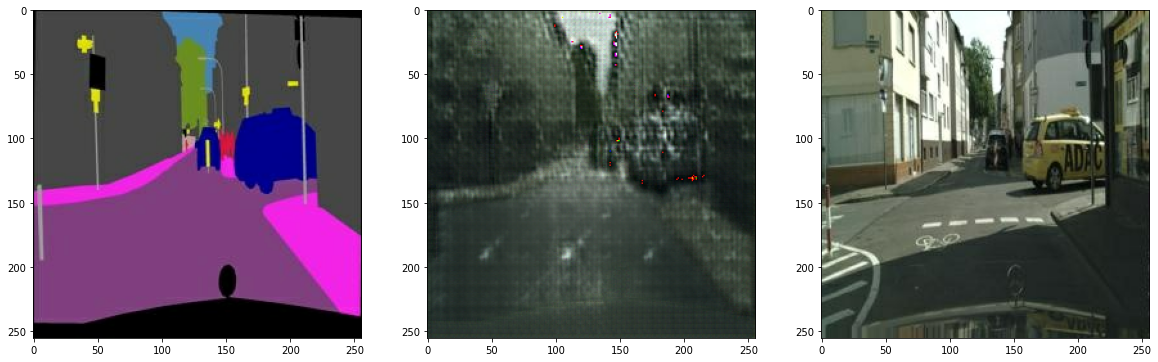

In [18]:
# Val 디렉토리 지정
val_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'

for test_ind in range(len(os.listdir(val_path))):

    f = val_path + os.listdir(val_path)[test_ind]
#     sketch, colored = load_img(f)
    colored, sketch = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))
    
plt.show()

- `(수행사항 5)` 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

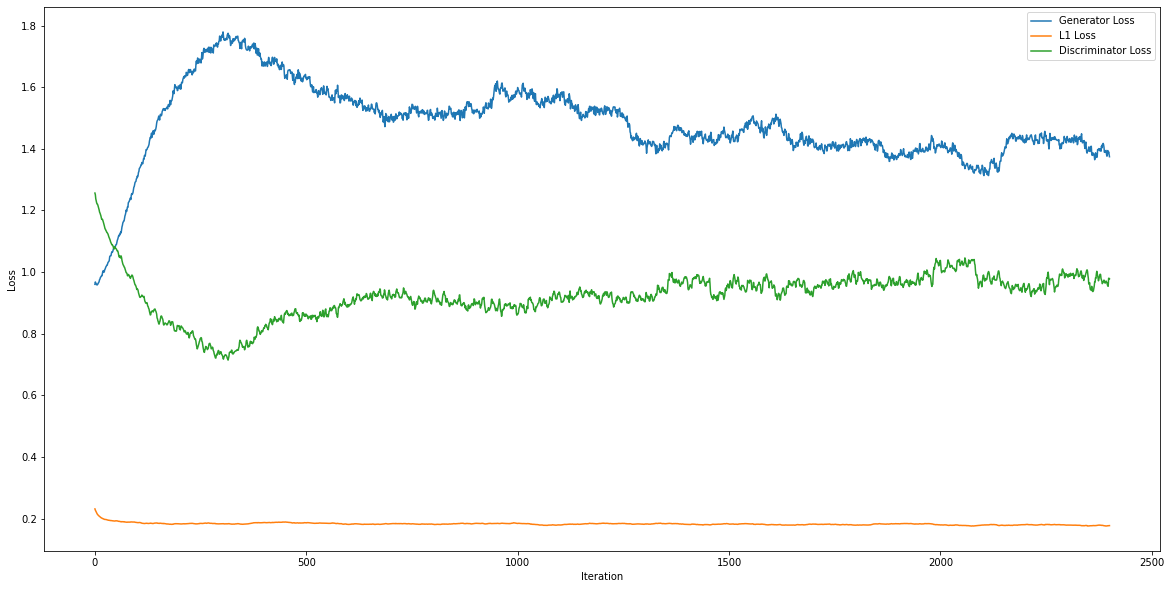

In [19]:
import numpy as np

# 평균 내고자 하는 개수
n = 100

# 손실 데이터 평균 계산
g_losses = np.convolve(g_losses, np.ones(n)/n, mode='valid')
l1_losses = np.convolve(l1_losses, np.ones(n)/n, mode='valid')
d_losses = np.convolve(d_losses, np.ones(n)/n, mode='valid')

# 손실 그래프 시각화
plt.figure(figsize=(20, 10))

plt.plot(g_losses, label='Generator Loss')
plt.plot(l1_losses, label='L1 Loss')
plt.plot(d_losses, label='Discriminator Loss')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()


# 300 에폭

- 실수로 날아감...